# Análisis de datos postura: *Goddess*

### Calculo de los angulos medios de la postura para determinar el angulo ideal de la postura

## Posture data analysis: *Goddess*

#### Calculation of mean stance angles to determine the ideal stance angle

In [1]:
# Import libraries
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
from matplotlib import pyplot as plt

### Definición de funciones de cálculo de ángulos

#### Definition of angle calculation functions

In [2]:
# Function for calculating the angles
def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [3]:
# Function to calculate the angles of the dataset

def angles_df(points, df, visibility):

    ang_points_coord= [[j+str(i)  for j in ['x', 'y', 'v']] for i in points]
    angle = []

    for j in range(df.shape[0]):
        l = []
        for i in ang_points_coord:
            if df[i[2]][j] > visibility:
                corr = (df[i[0]].iloc[j], df[i[1]].iloc[j])
                l.append(corr)
        if len(l) == 3:
            angle.append(int(calculate_angle_coord(l)))
    
    return angle

### Puntos para calcular el angulo

In [4]:
# Points for calculating the value angle of the middle of each tuple
#'Goddess'
p_list = [(11, 23, 25), 
        (12, 24, 26), 
        (23, 25, 27),
        (24, 26, 28)] 

![Alt text](..\interface\pages\Data\images_display\Landmarks.png)

### Representación de los puntos en imagen de la postura con su medición del ángulo

#### Representation of points in posture image with their angle measurement

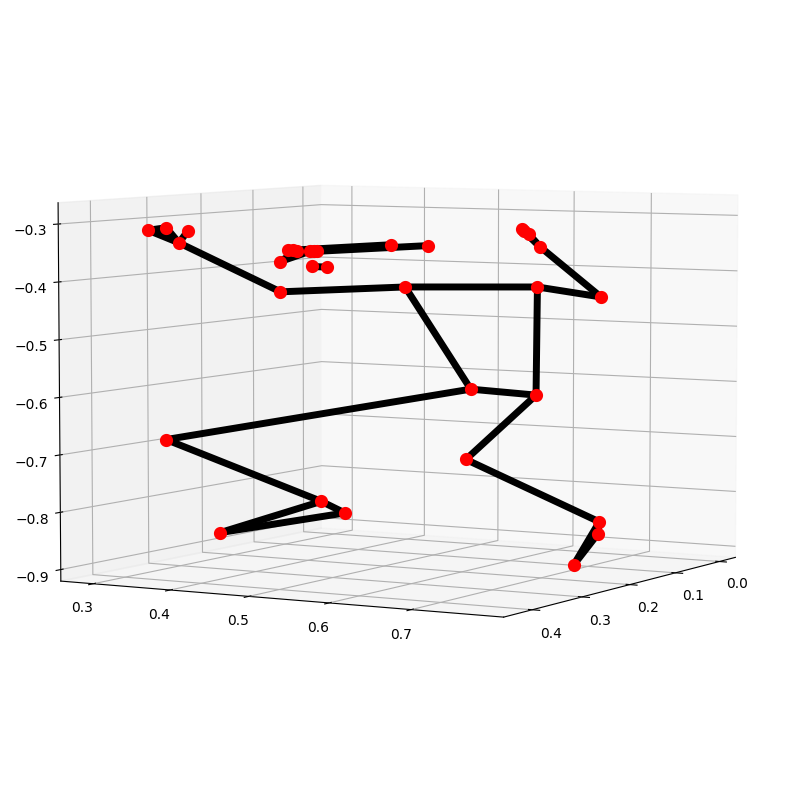

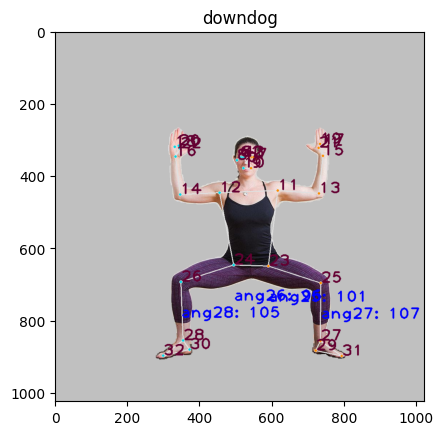

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:

path = '..\DATASET\TRAIN\goddess\\00000.jpg'
#image = cv2.imread(path)

IMAGE_FILES = [path]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
    landmrk_value = [l.value for l in mp_pose.PoseLandmark]

    text_size = int(round(np.linalg.norm(annotated_image.shape)*0.002,0))

    poses = results.pose_landmarks.landmark
    pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in poses]).flatten())

    for i in landmrk_value:
      if  results.pose_landmarks.landmark[i].visibility > 0.5 : 
        cv2.putText(annotated_image, str(i), (int((results.pose_landmarks.landmark[i].x)*annotated_image.shape[1]) , 
                                              int((results.pose_landmarks.landmark[i].y)*annotated_image.shape[0])),
                    cv2.FONT_HERSHEY_PLAIN, text_size, (50, 0, 100), text_size)
           
    
    for i in range(len(p_list)):
        p_cood_list = []
        midle_point = p_list[i][1]
        for p in p_list[i]:
            if results.pose_landmarks.landmark[p].visibility > 0.5:
                p_corrd = (results.pose_landmarks.landmark[p].x, results.pose_landmarks.landmark[p].y)
                p_cood_list.append(p_corrd)
            else:
                break

        try:
            angle = int(calculate_angle_coord(p_cood_list))
            cv2.putText(annotated_image, str(f'ang{p_list[i][2]}: {angle}'), (int((results.pose_landmarks.landmark[midle_point].x)*annotated_image.shape[1]) , 
                          100+int((results.pose_landmarks.landmark[midle_point].y)*annotated_image.shape[0])),
                          cv2.FONT_HERSHEY_PLAIN, text_size, (255,0,0), text_size)

        except:
            pass
      
   
    
    cv2.imwrite('images/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.

mp_drawing.plot_landmarks(results.pose_landmarks, mp_pose.POSE_CONNECTIONS, elevation = 5, azimuth= 30)

image_pose = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_pose)
plt.title('downdog')
plt.show()

## Carga del dataset

### Load dataset

In [6]:
df_goddess_train = pd.read_csv('../coord_dataset_csv/df_goddess_train.csv')
df_goddess_test = pd.read_csv('../coord_dataset_csv/df_goddess_test.csv')
df_goddess = pd.concat([df_goddess_train, df_goddess_test],
                         ignore_index=True)
df_goddess

,class,path,x0,y0,z0,v0,x1,y1,z1,v1,...,z30,v30,x31,y31,z31,v31,x32,y32,z32,v32
0,goddess,DATASET/TRAIN/goddess\00000.jpg,0.518398,0.355792,-0.424028,0.999997,0.527331,0.341360,-0.382112,0.999993,...,-0.072599,0.993941,0.774564,0.878404,-0.257829,0.983304,0.292297,0.877577,-0.214942,0.991525
1,goddess,DATASET/TRAIN/goddess\00001.jpg,0.514388,0.153620,-0.214369,0.999999,0.520888,0.132238,-0.185466,0.999998,...,-0.024034,0.992260,0.683170,0.950337,-0.121243,0.977001,0.359026,0.948178,-0.114138,0.988603
2,goddess,DATASET/TRAIN/goddess\00002.jpg,0.452639,0.256742,-0.442953,0.999999,0.463011,0.240115,-0.404662,0.999998,...,0.032017,0.996524,0.712191,0.888400,-0.084958,0.983476,0.175031,0.885095,-0.090774,0.994275
3,goddess,DATASET/TRAIN/goddess\00003.jpg,0.532042,0.216251,-0.228971,0.999997,0.538786,0.198419,-0.197811,0.999993,...,0.005367,0.988321,0.740449,0.873272,-0.104885,0.948327,0.318404,0.881033,-0.096195,0.975072
4,goddess,DATASET/TRAIN/goddess\00004.jpg,0.509706,0.197367,-0.455626,0.999998,0.524469,0.181773,-0.386020,0.999996,...,0.058457,0.989442,0.911847,0.897741,-0.100451,0.970803,0.067435,0.903563,-0.175494,0.990396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,goddess,DATASET/TEST/goddess\00262.jpg,0.498832,0.323186,-0.206722,0.999852,0.504862,0.309338,-0.171972,0.999822,...,0.033675,0.959351,0.710555,0.835603,-0.103750,0.905162,0.302732,0.864469,-0.065471,0.930237
263,goddess,DATASET/TEST/goddess\00263.jpg,0.522921,0.156055,-0.130181,0.999991,0.521284,0.137667,-0.096597,0.999985,...,-0.181968,0.983598,0.654681,0.869791,-0.273745,0.975785,0.292304,0.876342,-0.329700,0.990551
264,goddess,DATASET/TEST/goddess\00264.jpg,0.520839,0.163024,-0.107470,0.999983,0.519391,0.141341,-0.075525,0.999975,...,-0.274486,0.978207,0.657221,0.883514,-0.364473,0.972664,0.300457,0.877936,-0.436422,0.986644
265,goddess,DATASET/TEST/goddess\00265.jpg,0.535455,0.181385,-0.157362,0.999956,0.537515,0.156854,-0.113981,0.999951,...,-0.127648,0.976609,0.828731,0.873245,-0.259817,0.930485,0.239040,0.875215,-0.288621,0.973337


In [7]:
# Minimum visibility
visibility = 0.8

### Puntos a medir

#### Points to messure

In [8]:
# Points to messure
ang23_points  = [11,23,25]
ang24_points  = [12,24,26]
ang25_points  = [23,25,27]
ang26_points  = [24,26,28]

#### Punto 23

##### Point 23

In [9]:
ang23 = pd.DataFrame({'ang23':angles_df(ang23_points, df_goddess, visibility)})
ang23.describe()

,ang23
count,267.000000
mean,107.584270
std,15.957751
min,69.000000
25%,96.000000
50%,105.000000
75%,118.000000
max,151.000000


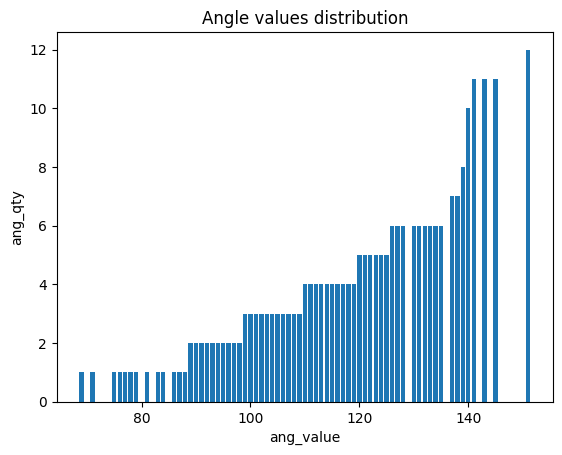

In [10]:
plt.bar(ang23['ang23'].sort_values().unique(), ang23['ang23'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 24

##### Point 24

In [11]:
ang24 = pd.DataFrame({'ang24':angles_df(ang24_points, df_goddess, visibility)})
ang24.describe()

,ang24
count,267.000000
mean,108.700375
std,16.313428
min,57.000000
25%,98.500000
50%,108.000000
75%,119.000000
max,150.000000


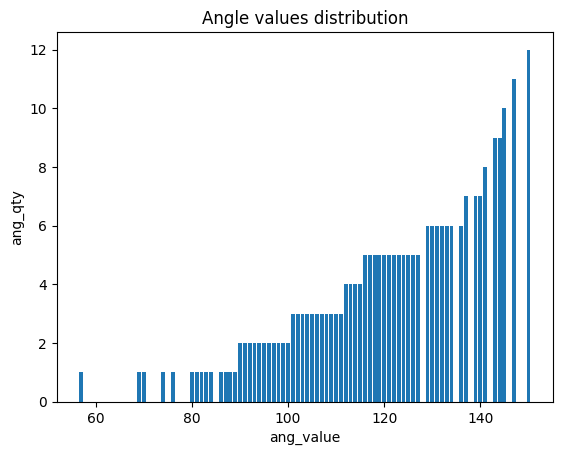

In [12]:
plt.bar(ang24['ang24'].sort_values().unique(), ang24['ang24'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 25

##### Point 25

In [13]:
ang25 = pd.DataFrame({'ang25':angles_df(ang25_points, df_goddess, visibility)})
ang25.describe()

,ang25
count,267.000000
mean,113.247191
std,16.854049
min,67.000000
25%,102.000000
50%,112.000000
75%,125.500000
max,160.000000


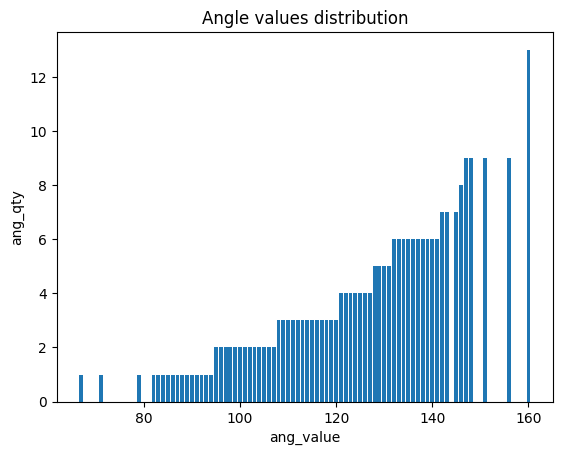

In [14]:
plt.bar(ang25['ang25'].sort_values().unique(), ang25['ang25'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

#### Punto 26

##### Point 26

In [15]:
ang26 = pd.DataFrame({'ang26':angles_df(ang26_points, df_goddess, visibility)})
ang26.describe()

,ang26
count,267.000000
mean,114.921348
std,16.713120
min,69.000000
25%,104.000000
50%,115.000000
75%,126.000000
max,160.000000


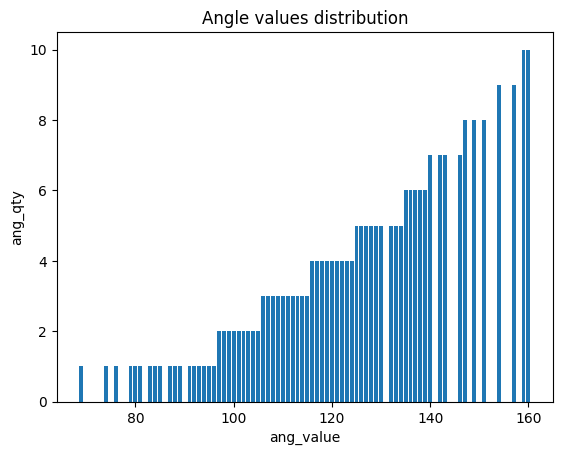

In [16]:
plt.bar(ang26['ang26'].sort_values().unique(), ang26['ang26'].value_counts().sort_values())
plt.xlabel("ang_value"), plt.ylabel("ang_qty"), plt.title('Angle values distribution')
plt.show()

## Valores medios de los ángulos para cada punto

### Average values of the angles for each point

In [17]:
results = pd.DataFrame({'ang: 23' : int(ang23.mean().item()), 
                        'ang: 24' : int(ang24.mean().item()), 
                        'ang: 25' : int(ang25.mean().item()),
                        'ang: 26' : int(ang26.mean().item())},
                        index=['mean'])
results

,ang: 23,ang: 24,ang: 25,ang: 26
mean,107,108,113,114
